# 임베딩 모델 - 19개 URL 특수문자 피처

이 노트북은 embedding_model의 구조를 그대로 유지하면서 19개의 URL 특수문자 피처로 학습합니다.

## 목표
- Autoencoder를 사용하여 19개 피처의 저차원 임베딩 생성
- Dataset1과 Dataset2를 통합한 균형잡힌 데이터로 학습
- 학습된 임베딩 공간에서 코사인 유사도를 사용한 피싱 탐지
- 정상/피싱 샘플의 프로토타입 벡터 생성 및 저장

## 프레임워크
1. 환경 초기화 (GPU 설정)
2. 데이터 로드 및 전처리
3. Autoencoder 모델 학습
4. 임베딩 공간에서 정상/피싱 프로토타입 생성
5. 유사도 기반 분류 성능 평가
6. 모델 및 결과 저장

===== 0) 모델 초기화 (Linux NVIDIA GPU) =====

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf

print(f"TensorFlow 버전: {tf.__version__}")

# NVIDIA GPU 확인 및 활성화
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✅ NVIDIA GPU 발견: {len(gpus)}개")
    for gpu in gpus:
        print(f"   - {gpu.name}")
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ GPU 메모리 동적 할당 활성화됨!")
    except RuntimeError as e:
        print(f"⚠️ 메모리 설정 실패: {e}")
else:
    print("⚠️ GPU가 발견되지 않았습니다. CPU를 사용합니다.")

# GPU 연산 테스트
print("\n=== GPU 연산 테스트 ===")
try:
    a = tf.random.normal([1000, 1000])
    b = tf.random.normal([1000, 1000])
    c = tf.matmul(a, b)
    print(f"✅ GPU 연산 테스트 완료: shape = {c.shape}")
except Exception as e:
    print(f"⚠️ GPU 연산 실패, CPU 사용: {e}")

tf.keras.backend.clear_session()
print("\n✅ TensorFlow 및 GPU 초기화 완료")

2025-12-03 22:13:14.990103: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-03 22:13:14.990148: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-03 22:13:14.990817: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow 버전: 2.15.0
✅ NVIDIA GPU 발견: 1개
   - /physical_device:GPU:0
✅ GPU 메모리 동적 할당 활성화됨!

=== GPU 연산 테스트 ===
✅ GPU 연산 테스트 완료: shape = (1000, 1000)

✅ TensorFlow 및 GPU 초기화 완료
✅ GPU 연산 테스트 완료: shape = (1000, 1000)

✅ TensorFlow 및 GPU 초기화 완료


===== 1) 환경 설정 및 Import =====

In [2]:
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import RobustScaler
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model

print(f"NumPy 버전: {np.__version__}")
print(f"Pandas 버전: {pd.__version__}")
print(f"TensorFlow 버전: {tf.__version__}")
print(f"Scikit-learn 버전: {__import__('sklearn').__version__}")
print("\n✅ 모든 라이브러리 Import 완료")

NumPy 버전: 1.26.4
Pandas 버전: 2.3.3
TensorFlow 버전: 2.15.0
Scikit-learn 버전: 1.7.2

✅ 모든 라이브러리 Import 완료


===== 2) 설정 =====

In [3]:
# 🔧 Linux 환경 경로
DATASET_DIR = '/home/wza/QR_Phishing/phishing/Deviation-in-Feature-Contribution-7760/Dataset'

# 학습 데이터
DATA1_TRAIN = os.path.join(DATASET_DIR, 'original_training_dataset1_70_30.csv')
DATA2_TRAIN = os.path.join(DATASET_DIR, 'Training/Dataset2/70_30_train.csv')

# 테스트 데이터
DATA1_TEST = os.path.join(DATASET_DIR, 'Testing/Dataset1/70_30_test.csv')
DATA2_TEST = os.path.join(DATASET_DIR, 'Testing/Dataset2/70_30_test.csv')

# 모델 설정
EMBEDDING_DIM = 32
BATCH_SIZE = 16
EPOCHS = 200
LEARNING_RATE = 0.0001
RANDOM_SEED = 42
L2_REG = 0.0001

# 시드 설정
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# 19개 피처 (url_google_index 제외)
FEATURE_NAMES = [
    'qty_dot_url', 'qty_hyphen_url', 'qty_underline_url', 'qty_slash_url',
    'qty_questionmark_url', 'qty_equal_url', 'qty_at_url', 'qty_and_url',
    'qty_tilde_url', 'qty_comma_url', 'qty_asterisk_url', 'qty_percent_url',
    'qty_dollar_url', 'tld_present_params', 'qty_redirects', 'length_url',
    'url_shortened', 'domain_length', 'domain_in_ip'
]

# Dataset2 컬럼 매핑
DATASET2_COLS = {
    'total_of.': 'qty_dot_url',
    'total_of-': 'qty_hyphen_url',
    'total_of_': 'qty_underline_url',
    'total_of/': 'qty_slash_url',
    'total_of?': 'qty_questionmark_url',
    'total_of=': 'qty_equal_url',
    'total_of@': 'qty_at_url',
    'total_of&': 'qty_and_url',
    'total_of~': 'qty_tilde_url',
    'total_of,': 'qty_comma_url',
    'total_of*': 'qty_asterisk_url',
    'total_of%': 'qty_percent_url',
    'total_of$': 'qty_dollar_url',
    'tld_in_path': 'tld_present_params',
    'nb_redirection': 'qty_redirects',
    'url_length': 'length_url',
    'shortening_service': 'url_shortened',
    'hostname_length': 'domain_length',
    'ip': 'domain_in_ip',
    'status': 'phishing'
}

print("\n" + "="*80)
print("🔧 설정")
print("="*80)
print(f"Random Seed: {RANDOM_SEED}")
print(f"피처 개수: {len(FEATURE_NAMES)}")
print(f"임베딩 차원: {EMBEDDING_DIM}")
print(f"배치 크기: {BATCH_SIZE}, 에폭: {EPOCHS}")
print(f"Learning Rate: {LEARNING_RATE}, L2 Regularization: {L2_REG}")


🔧 설정
Random Seed: 42
피처 개수: 19
임베딩 차원: 32
배치 크기: 16, 에폭: 200
Learning Rate: 0.0001, L2 Regularization: 0.0001


===== 3) 데이터 로드 =====

In [4]:
print("\n" + "="*80)
print("📂 데이터 로드 중...")
print("="*80)

# 학습 데이터 로드
df1_train = pd.read_csv(DATA1_TRAIN, encoding='utf-8', engine='python')
df2_train = pd.read_csv(DATA2_TRAIN, encoding='utf-8', engine='python')

print(f"\n✅ 학습 데이터 로드 완료:")
print(f"   - Dataset1 Train: {df1_train.shape}")
print(f"   - Dataset2 Train: {df2_train.shape}")
print(f"   - 클래스 분포 (D1): {df1_train['phishing'].value_counts().to_dict()}")
print(f"   - 클래스 분포 (D2): {df2_train['status'].value_counts().to_dict()}")

# 테스트 데이터 로드
df1_test = pd.read_csv(DATA1_TEST, encoding='utf-8', engine='python')
df2_test = pd.read_csv(DATA2_TEST, encoding='utf-8', engine='python')

print(f"\n✅ 테스트 데이터 로드 완료:")
print(f"   - Dataset1 Test: {df1_test.shape}")
print(f"   - Dataset2 Test: {df2_test.shape}")


📂 데이터 로드 중...

✅ 학습 데이터 로드 완료:
   - Dataset1 Train: (67222, 99)
   - Dataset2 Train: (13601, 80)
   - 클래스 분포 (D1): {0: 40614, 1: 26608}
   - 클래스 분포 (D2): {0: 6831, 1: 6770}

✅ 학습 데이터 로드 완료:
   - Dataset1 Train: (67222, 99)
   - Dataset2 Train: (13601, 80)
   - 클래스 분포 (D1): {0: 40614, 1: 26608}
   - 클래스 분포 (D2): {0: 6831, 1: 6770}

✅ 테스트 데이터 로드 완료:
   - Dataset1 Test: (26595, 99)
   - Dataset2 Test: (5830, 80)

✅ 테스트 데이터 로드 완료:
   - Dataset1 Test: (26595, 99)
   - Dataset2 Test: (5830, 80)


===== 4) 데이터 전처리 (19개 피처만 선택, 50:50 균형 분할) =====

In [5]:
print("\n" + "="*80)
print("🔄 학습 데이터 전처리")
print("="*80)

# Dataset1에서 19개 피처 선택
X1_train = df1_train[FEATURE_NAMES].values.astype(np.float32)
y1_train = df1_train['phishing'].values.astype(np.float32)

print(f"\n✅ Dataset1 학습 데이터:")
print(f"   - X shape: {X1_train.shape}")
print(f"   - 클래스 분포: {np.bincount(y1_train.astype(int))}")

# Dataset2 컬럼 이름 변경
df2_train_renamed = df2_train.rename(columns=DATASET2_COLS)
X2_train = df2_train_renamed[FEATURE_NAMES].values.astype(np.float32)
y2_train = df2_train_renamed['phishing'].values.astype(np.float32)

print(f"\n✅ Dataset2 학습 데이터:")
print(f"   - X shape: {X2_train.shape}")
print(f"   - 클래스 분포: {np.bincount(y2_train.astype(int))}")


🔄 학습 데이터 전처리

✅ Dataset1 학습 데이터:
   - X shape: (67222, 19)
   - 클래스 분포: [40614 26608]

✅ Dataset2 학습 데이터:
   - X shape: (13601, 19)
   - 클래스 분포: [6831 6770]


In [6]:
# ===== 50:50 균형 분할 함수 =====
def split_class(X, y, train_ratio=0.6, val_ratio=0.2, seed=42):
    """클래스별로 train/val/test 분할"""
    # 여러 번 셔플해서 패턴 편향 방지
    indices = np.arange(len(X))
    for i in range(3):
        np.random.seed(seed + i)
        np.random.shuffle(indices)
    
    X_shuffled = X[indices]
    y_shuffled = y[indices]
    
    n = len(X_shuffled)
    train_end = int(n * train_ratio)
    val_end = int(n * (train_ratio + val_ratio))
    
    return (X_shuffled[:train_end], y_shuffled[:train_end],
            X_shuffled[train_end:val_end], y_shuffled[train_end:val_end],
            X_shuffled[val_end:], y_shuffled[val_end:])

# 클래스별로 분리
X1_phish = X1_train[y1_train == 1]
y1_phish = y1_train[y1_train == 1]
X1_legit = X1_train[y1_train == 0]
y1_legit = y1_train[y1_train == 0]

# 각 클래스별로 60/20/20 분할
X1_phish_tr, y1_phish_tr, X1_phish_val, y1_phish_val, X1_phish_te, y1_phish_te = split_class(X1_phish, y1_phish, seed=RANDOM_SEED)
X1_legit_tr, y1_legit_tr, X1_legit_val, y1_legit_val, X1_legit_te, y1_legit_te = split_class(X1_legit, y1_legit, seed=RANDOM_SEED)

# 균형잡힌 D1 + D2
X_merged_train = np.vstack([X1_phish_tr, X1_legit_tr, X2_train])
y_merged_train = np.hstack([y1_phish_tr, y1_legit_tr, y2_train])

# 셔플
indices = np.arange(len(X_merged_train))
np.random.shuffle(indices)
X_merged_train = X_merged_train[indices]
y_merged_train = y_merged_train[indices]

print(f"\n✅ Dataset1 균형 조정 (60/20/20 분할):")
print(f"   - Train: 피싱{int((y1_phish_tr==1).sum())}, 정상{int((y1_legit_tr==0).sum())}")
print(f"   - Val: 피싱{int((y1_phish_val==1).sum())}, 정상{int((y1_legit_val==0).sum())}")
print(f"   - Test: 피싱{int((y1_phish_te==1).sum())}, 정상{int((y1_legit_te==0).sum())}")

print(f"\n✅ 통합 학습 데이터:")
print(f"   - X shape: {X_merged_train.shape}")
print(f"   - 클래스 분포: {np.bincount(y_merged_train.astype(int))}")
print(f"   - 피싱 비율: {y_merged_train.mean()*100:.2f}%")


✅ Dataset1 균형 조정 (60/20/20 분할):
   - Train: 피싱15964, 정상24368
   - Val: 피싱5322, 정상8123
   - Test: 피싱5322, 정상8123

✅ 통합 학습 데이터:
   - X shape: (53933, 19)
   - 클래스 분포: [31199 22734]
   - 피싱 비율: 42.15%


===== 5) 검증/테스트 데이터 준비 =====

In [7]:
print("\n" + "="*80)
print("🔄 검증/테스트 데이터 준비")
print("="*80)

# Dataset1 검증/테스트
X_val = np.vstack([X1_phish_val, X1_legit_val])
y_val = np.hstack([y1_phish_val, y1_legit_val])

X1_test_arr = df1_test[FEATURE_NAMES].values.astype(np.float32)
y1_test_arr = df1_test['phishing'].values.astype(np.float32)

# Dataset2 테스트
df2_test_renamed = df2_test.rename(columns=DATASET2_COLS)
X2_test_arr = df2_test_renamed[FEATURE_NAMES].values.astype(np.float32)
y2_test_arr = df2_test_renamed['phishing'].values.astype(np.float32)

# 통합 테스트
X_test = np.vstack([X1_test_arr, X2_test_arr])
y_test = np.hstack([y1_test_arr, y2_test_arr])

# 셔플
indices = np.arange(len(X_val))
np.random.shuffle(indices)
X_val = X_val[indices]
y_val = y_val[indices]

indices = np.arange(len(X_test))
np.random.shuffle(indices)
X_test = X_test[indices]
y_test = y_test[indices]

print(f"\n✅ Validation: {X_val.shape} - 피싱:{int((y_val==1).sum())}, 정상:{int((y_val==0).sum())}")
print(f"✅ Test (D1): {X1_test_arr.shape}")
print(f"✅ Test (D2): {X2_test_arr.shape}")
print(f"✅ Test (Merged): {X_test.shape} - 피싱:{int((y_test==1).sum())}, 정상:{int((y_test==0).sum())}")


🔄 검증/테스트 데이터 준비

✅ Validation: (13445, 19) - 피싱:5322, 정상:8123
✅ Test (D1): (26595, 19)
✅ Test (D2): (5830, 19)
✅ Test (Merged): (32425, 19) - 피싱:12154, 정상:20271


===== 6) 데이터 정규화 =====

In [8]:
print("\n" + "="*80)
print("📊 데이터 정규화 (RobustScaler)")
print("="*80)

robust_scaler = RobustScaler()

# 학습 데이터로 fit
X_merged_train_scaled = robust_scaler.fit_transform(X_merged_train).astype(np.float32)
X_val_scaled = robust_scaler.transform(X_val).astype(np.float32)
X_test_scaled = robust_scaler.transform(X_test).astype(np.float32)

print(f"✅ RobustScaler 적용 완료")
print(f"   - Train: min={X_merged_train_scaled.min():.4f}, max={X_merged_train_scaled.max():.4f}")
print(f"   - Train: mean={X_merged_train_scaled.mean():.4f}, std={X_merged_train_scaled.std():.4f}")


📊 데이터 정규화 (RobustScaler)
✅ RobustScaler 적용 완료
   - Train: min=-1.7500, max=174.0000
   - Train: mean=0.1706, std=0.9165


===== 7) Autoencoder 모델 구축 =====

In [9]:
print("\n" + "="*80)
print("🏗️ Autoencoder 모델 구축")
print("="*80)

keras.backend.clear_session()
gc.collect()

input_dim = X_merged_train_scaled.shape[1]

# Encoder
encoder_input = keras.Input(shape=(input_dim,), name='encoder_input')

x = layers.Dense(64, activation='relu',
                 kernel_initializer='he_normal',
                 kernel_regularizer=keras.regularizers.l2(L2_REG),
                 name='encoder_dense1')(encoder_input)

x = layers.Dense(32, activation='relu',
                 kernel_initializer='he_normal',
                 kernel_regularizer=keras.regularizers.l2(L2_REG),
                 name='encoder_dense2')(x)

# 임베딩 레이어
embedding = layers.Dense(EMBEDDING_DIM, activation='relu',
                          kernel_regularizer=keras.regularizers.l2(L2_REG),
                          name='embedding')(x)

# Decoder
x = layers.Dense(32, activation='relu',
                 kernel_initializer='he_normal',
                 kernel_regularizer=keras.regularizers.l2(L2_REG),
                 name='decoder_dense1')(embedding)

x = layers.Dense(64, activation='relu',
                 kernel_initializer='he_normal',
                 kernel_regularizer=keras.regularizers.l2(L2_REG),
                 name='decoder_dense2')(x)

decoder_output = layers.Dense(input_dim, activation='linear',
                               name='decoder_output')(x)

# Autoencoder 모델
autoencoder = Model(encoder_input, decoder_output, name='autoencoder')

# 임베딩 모델 (inference용)
embedding_model = Model(encoder_input, embedding, name='embedding_model')

# 컴파일 (메트릭 추가)
optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
autoencoder.compile(
    optimizer=optimizer,
    loss='mse',
    metrics=[keras.metrics.BinaryAccuracy(name='accuracy'), keras.metrics.AUC(name='auc')]
)

print(f"\n✅ 모델 구축 완료")
print(f"\nAutoencoder 구조:")
autoencoder.summary()


🏗️ Autoencoder 모델 구축

✅ 모델 구축 완료

Autoencoder 구조:
Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 19)]              0         
                                                                 
 encoder_dense1 (Dense)      (None, 64)                1280      
                                                                 
 encoder_dense2 (Dense)      (None, 32)                2080      
                                                                 
 embedding (Dense)           (None, 32)                1056      
                                                                 
 decoder_dense1 (Dense)      (None, 32)                1056      
                                                                 
 decoder_dense2 (Dense)      (None, 64)                2112      
                                                                 
 dec

===== 8) 모델 학습 =====

In [10]:
print("\n" + "="*80)
print("🚀 모델 학습 중...")
print("="*80)

# 콜백 설정
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=0
)

# 학습
history = autoencoder.fit(
    X_merged_train_scaled, X_merged_train_scaled,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val_scaled, X_val_scaled),
    callbacks=[early_stopping],
    verbose=1
)

print(f"\n✅ 학습 완료")
print(f"   - 최종 Train Loss: {history.history['loss'][-1]:.6f}")
print(f"   - 최종 Val Loss: {history.history['val_loss'][-1]:.6f}")


🚀 모델 학습 중...
Epoch 1/200


I0000 00:00:1764767619.497646    9393 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3371/3371 [==============================] - 17s 4ms/step - loss: 0.4908 - accuracy: 0.7510 - auc: 0.6690 - val_loss: 0.1422 - val_accuracy: 0.7934 - val_auc: 0.6139
Epoch 2/200
3371/3371 [==============================] - 17s 4ms/step - loss: 0.4908 - accuracy: 0.7510 - auc: 0.6690 - val_loss: 0.1422 - val_accuracy: 0.7934 - val_auc: 0.6139
Epoch 2/200
3371/3371 [==============================] - 15s 4ms/step - loss: 0.1409 - accuracy: 0.7917 - auc: 0.7109 - val_loss: 0.0796 - val_accuracy: 0.8099 - val_auc: 0.6361
Epoch 3/200
3371/3371 [==============================] - 15s 4ms/step - loss: 0.1409 - accuracy: 0.7917 - auc: 0.7109 - val_loss: 0.0796 - val_accuracy: 0.8099 - val_auc: 0.6361
Epoch 3/200
3371/3371 [==============================] - 14s 4ms/step - loss: 0.0910 - accuracy: 0.8054 - auc: 0.7233 - val_loss: 0.0639 - val_accuracy: 0.8140 - val_auc: 0.6432
Epoch 4/200
3371/3371 [==============================] - 14s 4ms/step - loss: 0.0910 - accuracy: 0.8054 - auc: 0.7233 - va

===== 9) 임베딩 벡터 생성 =====

In [11]:
print("\n" + "="*80)
print("🔍 임베딩 벡터 생성")
print("="*80)

# 모든 데이터의 임베딩 생성
embeddings_train = embedding_model.predict(X_merged_train_scaled, verbose=0)
embeddings_test = embedding_model.predict(X_test_scaled, verbose=0)

print(f"\n✅ 임베딩 생성 완료")
print(f"   - Train 임베딩: {embeddings_train.shape}")
print(f"   - Test 임베딩: {embeddings_test.shape}")

# 정상/피싱 프로토타입 계산
legit_mask = y_merged_train == 0
phish_mask = y_merged_train == 1

prototype_legit = embeddings_train[legit_mask].mean(axis=0, keepdims=True)
prototype_phish = embeddings_train[phish_mask].mean(axis=0, keepdims=True)

print(f"\n✅ 프로토타입 계산 완료")
print(f"   - 정상 프로토타입: {prototype_legit.shape}")
print(f"   - 피싱 프로토타입: {prototype_phish.shape}")


🔍 임베딩 벡터 생성

✅ 임베딩 생성 완료
   - Train 임베딩: (53933, 32)
   - Test 임베딩: (32425, 32)

✅ 프로토타입 계산 완료
   - 정상 프로토타입: (1, 32)
   - 피싱 프로토타입: (1, 32)

✅ 임베딩 생성 완료
   - Train 임베딩: (53933, 32)
   - Test 임베딩: (32425, 32)

✅ 프로토타입 계산 완료
   - 정상 프로토타입: (1, 32)
   - 피싱 프로토타입: (1, 32)


===== 10) 유사도 기반 분류 평가 =====

In [12]:
print("\n" + "="*80)
print("📊 유사도 기반 분류 평가")
print("="*80)

# 테스트 데이터의 유사도 계산
sim_legit = cosine_similarity(embeddings_test, prototype_legit).flatten()
sim_phish = cosine_similarity(embeddings_test, prototype_phish).flatten()

# 예측: 정상에 더 가까우면 0, 피싱에 더 가까우면 1
y_pred_emb = (sim_phish > sim_legit).astype(int)
y_pred_proba_emb = sim_phish / (sim_legit + sim_phish)  # 정규화된 확률

# 성능 평가
acc_emb = accuracy_score(y_test, y_pred_emb)
prec_emb = precision_score(y_test, y_pred_emb, zero_division=0)
rec_emb = recall_score(y_test, y_pred_emb, zero_division=0)
f1_emb = f1_score(y_test, y_pred_emb, zero_division=0)
auc_emb = roc_auc_score(y_test, y_pred_proba_emb)

print(f"\n📈 유사도 기반 분류 성능:")
print(f"   - Accuracy:  {acc_emb:.4f}")
print(f"   - Precision: {prec_emb:.4f}")
print(f"   - Recall:    {rec_emb:.4f}")
print(f"   - F1 Score:  {f1_emb:.4f}")
print(f"   - AUC:       {auc_emb:.4f}")

print(f"\n📋 분류 리포트:")
print(classification_report(y_test, y_pred_emb, target_names=['정상(0)', '피싱(1)']))


📊 유사도 기반 분류 평가

📈 유사도 기반 분류 성능:
   - Accuracy:  0.7670
   - Precision: 0.7199
   - Recall:    0.6195
   - F1 Score:  0.6659
   - AUC:       0.8546

📋 분류 리포트:
              precision    recall  f1-score   support

       정상(0)       0.79      0.86      0.82     20271
       피싱(1)       0.72      0.62      0.67     12154

    accuracy                           0.77     32425
   macro avg       0.75      0.74      0.74     32425
weighted avg       0.76      0.77      0.76     32425



===== 11) 시각화 - 학습 곡선 및 성능 메트릭 =====


📊 임베딩 모델 성능 메트릭
   Metric  Embedding_Model
 Accuracy         0.767001
Precision         0.719858
   Recall         0.619467
 F1 Score         0.665900
      AUC         0.854646


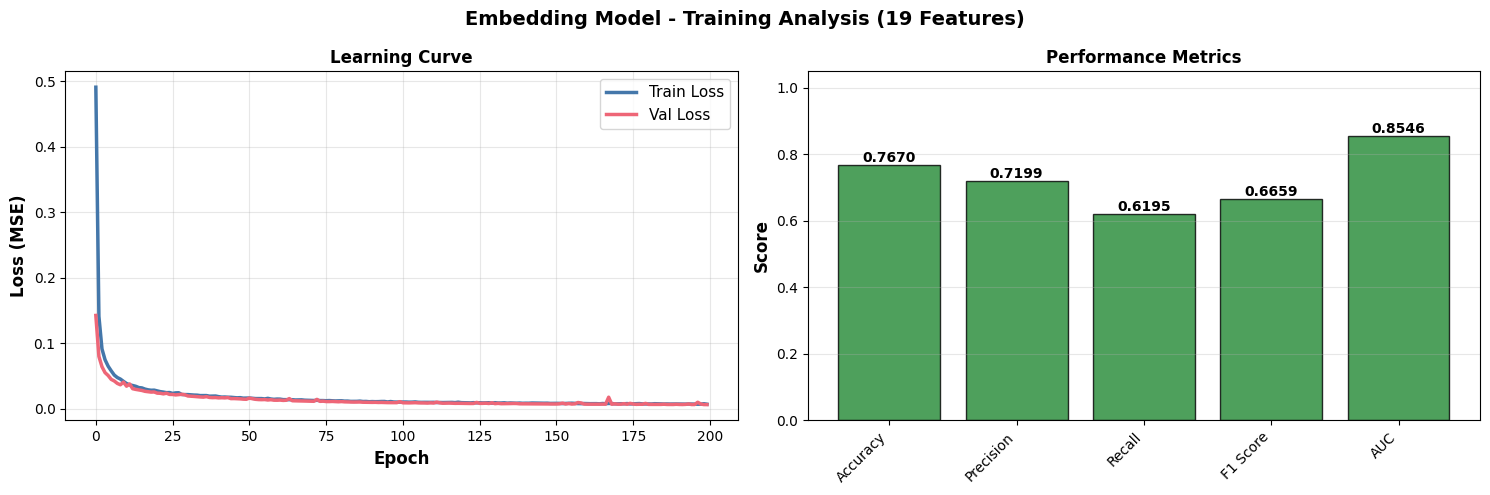


✅ Learning curve and performance metrics visualization complete


In [13]:
# 성능 메트릭 저장
performance_data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'],
    'Embedding_Model': [acc_emb, prec_emb, rec_emb, f1_emb, auc_emb]
}
performance_df = pd.DataFrame(performance_data)

print("\n" + "="*80)
print("📊 임베딩 모델 성능 메트릭")
print("="*80)
print(performance_df.to_string(index=False))
print("="*80)

# 학습 곡선 및 성능 메트릭 시각화
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Embedding Model - Training Analysis (19 Features)', fontsize=14, fontweight='bold')

# 1. 학습 곡선
ax = axes[0]
ax.plot(history.history['loss'], label='Train Loss', linewidth=2.5, color='#4477AA')
ax.plot(history.history['val_loss'], label='Val Loss', linewidth=2.5, color='#EE6677')
ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax.set_ylabel('Loss (MSE)', fontsize=12, fontweight='bold')
ax.set_title('Learning Curve', fontsize=12, fontweight='bold')
ax.legend(fontsize=11, loc='upper right')
ax.grid(True, alpha=0.3)

# 2. 성능 메트릭 바 차트
ax = axes[1]
metrics_names = performance_df['Metric'].values
metrics_values = performance_df['Embedding_Model'].values
bars = ax.bar(range(len(metrics_names)), metrics_values, color='#228833', alpha=0.8, edgecolor='black')
ax.set_xticks(range(len(metrics_names)))
ax.set_xticklabels(metrics_names, rotation=45, ha='right')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Performance Metrics', fontsize=12, fontweight='bold')
ax.set_ylim([0, 1.05])
ax.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✅ Learning curve and performance metrics visualization complete")

===== 12) 시각화 - ROC 곡선 및 성능 분석 =====

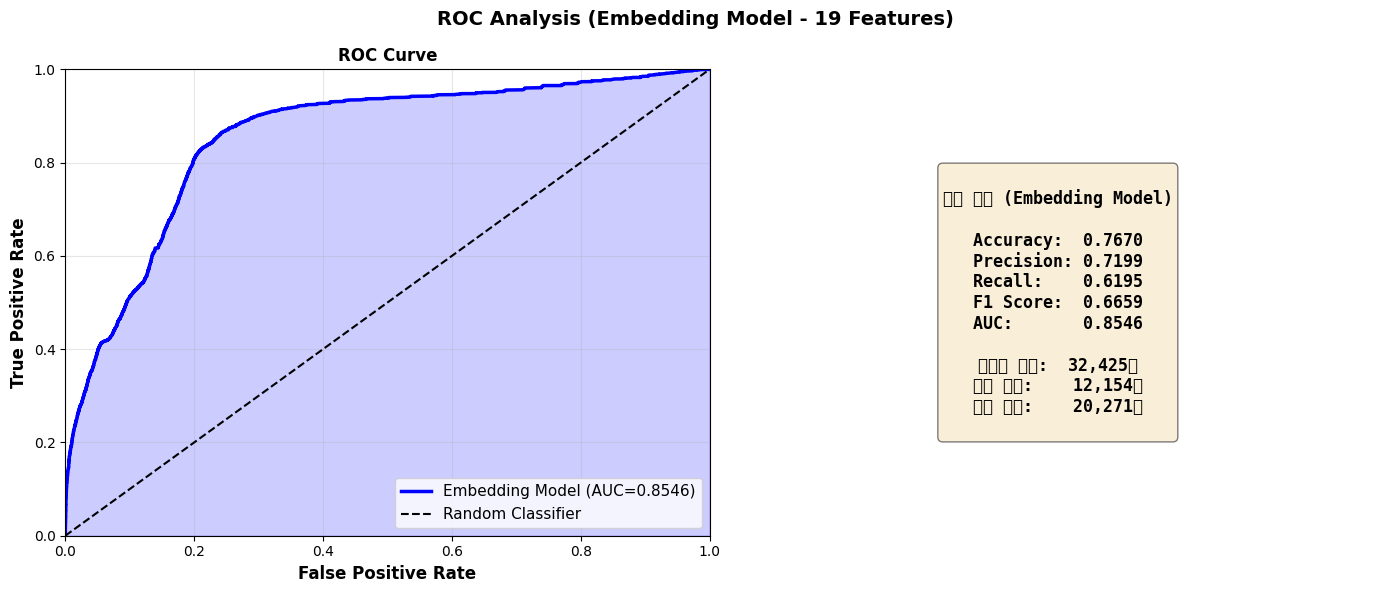

✅ ROC curve and performance analysis visualization complete


In [14]:
# ROC 곡선 및 성능 메트릭
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('ROC Analysis (Embedding Model - 19 Features)', fontsize=14, fontweight='bold')

# 1. ROC 곡선
ax = axes[0]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_emb)
ax.plot(fpr, tpr, 'b-', linewidth=2.5, label=f'Embedding Model (AUC={auc_emb:.4f})')
ax.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Random Classifier')
ax.fill_between(fpr, tpr, alpha=0.2, color='blue')
ax.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
ax.set_title('ROC Curve', fontsize=12, fontweight='bold')
ax.legend(fontsize=11, loc='lower right')
ax.grid(True, alpha=0.3)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

# 2. AUC 및 성능 메트릭 표시
ax = axes[1]
ax.axis('off')
metrics_text = f"""
성능 분석 (Embedding Model)

Accuracy:  {acc_emb:.4f}
Precision: {prec_emb:.4f}
Recall:    {rec_emb:.4f}
F1 Score:  {f1_emb:.4f}
AUC:       {auc_emb:.4f}

테스트 샘플:  {len(y_test):,}개
피싱 샘플:    {int((y_test==1).sum()):,}개
정상 샘플:    {int((y_test==0).sum()):,}개
"""
ax.text(0.5, 0.5, metrics_text, fontsize=12, ha='center', va='center',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
        family='monospace', fontweight='bold')

plt.tight_layout()
plt.show()

print("✅ ROC curve and performance analysis visualization complete")

===== 13) 시각화 - Confusion Matrix =====

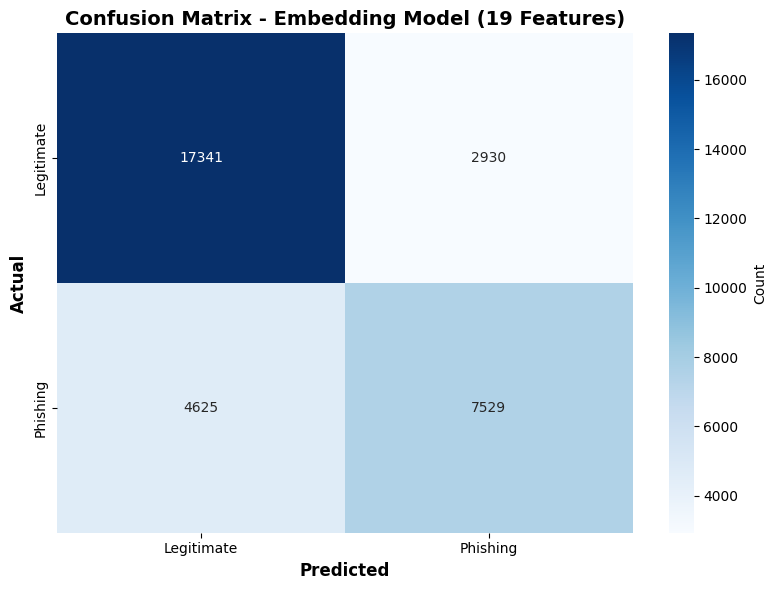

✅ Confusion matrix visualization complete


In [15]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_emb)

fig, ax = plt.subplots(figsize=(8, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=['Legitimate', 'Phishing'],
            yticklabels=['Legitimate', 'Phishing'],
            cbar_kws={'label': 'Count'})

ax.set_ylabel('Actual', fontsize=12, fontweight='bold')
ax.set_xlabel('Predicted', fontsize=12, fontweight='bold')
ax.set_title('Confusion Matrix - Embedding Model (19 Features)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("✅ Confusion matrix visualization complete")

===== 14) 시각화 - 임베딩 공간 분포 (t-SNE) =====

In [16]:
# t-SNE를 사용한 임베딩 공간 시각화
from sklearn.manifold import TSNE

print("t-SNE 처리 중 (시간이 걸릴 수 있습니다)...")

# 샘플링 (모든 데이터를 사용하면 느리므로 10,000개만 사용)
sample_size = min(10000, len(embeddings_test))
indices = np.random.choice(len(embeddings_test), sample_size, replace=False)

embeddings_test_sample = embeddings_test[indices]
y_test_sample = y_test[indices]

# t-SNE
tsne = TSNE(n_components=2, random_state=RANDOM_SEED, n_iter=1000)
embeddings_2d = tsne.fit_transform(embeddings_test_sample)

# 시각화
fig, ax = plt.subplots(figsize=(12, 9))

legit_mask = y_test_sample == 0
phish_mask = y_test_sample == 1

ax.scatter(embeddings_2d[legit_mask, 0], embeddings_2d[legit_mask, 1],
           c='blue', label='Legitimate', alpha=0.6, s=30, edgecolors='none')
ax.scatter(embeddings_2d[phish_mask, 0], embeddings_2d[phish_mask, 1],
           c='red', label='Phishing', alpha=0.6, s=30, edgecolors='none')

# 프로토타입 표시
prototype_legit_2d = tsne.transform(prototype_legit)
prototype_phish_2d = tsne.transform(prototype_phish)

ax.scatter(prototype_legit_2d[:, 0], prototype_legit_2d[:, 1],
           c='darkblue', marker='*', s=500, edgecolors='black', linewidths=2, label='Legit Prototype')
ax.scatter(prototype_phish_2d[:, 0], prototype_phish_2d[:, 1],
           c='darkred', marker='*', s=500, edgecolors='black', linewidths=2, label='Phish Prototype')

ax.set_xlabel('t-SNE 1', fontsize=12)
ax.set_ylabel('t-SNE 2', fontsize=12)
ax.set_title('Embedding Space Distribution (t-SNE) - 19 Features', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ t-SNE visualization complete")

t-SNE 처리 중 (시간이 걸릴 수 있습니다)...


TypeError: TSNE.__init__() got an unexpected keyword argument 'n_iter'

===== 15) 결과 저장 =====

In [ ]:
import json

output_dir = '/home/wza/QR_Phishing/phishing/Deviation-in-Feature-Contribution-7760/Code'

print("\n" + "="*80)
print("💾 결과 저장 중...")
print("="*80)

# 1. 학습된 모델 저장
autoencoder.save(f'{output_dir}/embedding_model_19features.h5')
print(f"✅ Autoencoder 모델 저장: {output_dir}/embedding_model_19features.h5")

# 2. 프로토타입 벡터 저장
np.save(f'{output_dir}/prototype_legit_19features.npy', prototype_legit)
np.save(f'{output_dir}/prototype_phish_19features.npy', prototype_phish)
print(f"✅ 프로토타입 벡터 저장 완료")

# 3. 성능 메트릭 저장
results_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'],
    'Embedding_Model': [acc_emb, prec_emb, rec_emb, f1_emb, auc_emb]
})
results_df.to_csv(f'{output_dir}/embedding_model_19features_performance.csv', index=False)
print(f"✅ 성능 메트릭 저장: {output_dir}/embedding_model_19features_performance.csv")

# 4. Scaler 파라미터 저장
scaler_params = {
    'type': 'robust_scaler',
    'center': robust_scaler.center_.tolist(),
    'scale': robust_scaler.scale_.tolist(),
    'feature_names': FEATURE_NAMES
}
with open(f'{output_dir}/scaler_params_19features.json', 'w') as f:
    json.dump(scaler_params, f, indent=2)
print(f"✅ Scaler 파라미터 저장: {output_dir}/scaler_params_19features.json")

print(f"\n📁 모든 파일 저장 완료!")

===== 16) 최종 요약 =====

In [ ]:
print("\n" + "="*80)
print("📋 최종 요약")
print("="*80)

print(f"\n✅ 데이터 정보:")
print(f"   - 피처 개수: {len(FEATURE_NAMES)}")
print(f"   - 학습 데이터: {X_merged_train_scaled.shape[0]:,} 샘플")
print(f"   - 테스트 데이터: {X_test_scaled.shape[0]:,} 샘플")

print(f"\n✅ 모델 설정:")
print(f"   - 프레임워크: TensorFlow Keras (Autoencoder)")
print(f"   - 임베딩 차원: {EMBEDDING_DIM}")
print(f"   - 배치 크기: {BATCH_SIZE}")
print(f"   - Learning Rate: {LEARNING_RATE}")
print(f"   - L2 Regularization: {L2_REG}")

print(f"\n✅ 최종 성능 (유사도 기반 분류):")
print(f"   - Accuracy:  {acc_emb:.4f}")
print(f"   - Precision: {prec_emb:.4f}")
print(f"   - Recall:    {rec_emb:.4f}")
print(f"   - F1 Score:  {f1_emb:.4f}")
print(f"   - AUC:       {auc_emb:.4f}")

print(f"\n✅ 저장된 파일:")
print(f"   - embedding_model_19features.h5")
print(f"   - prototype_legit_19features.npy")
print(f"   - prototype_phish_19features.npy")
print(f"   - embedding_model_19features_performance.csv")
print(f"   - scaler_params_19features.json")

print("\n" + "="*80)
print("🎉 분석 완료!")
print("="*80)